# Finding the Best Striker in FM23

This projects aims to solve the task of finding the best suited striker in the simulation game "Football Manager 2023" (FM23) through the use of data. The data is loaded from a local folder but originally found on Kaggle.com. The dataset has data for all players in the game with many attributes that will not be needed in the project. Thus, the dataset will be cleaned thoroughly before any calculation or analysis will be carried out

Imports and set magics:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


/Users/ditlevholm/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Read data

I check the existence of my folder, import data and load it. I then present the first 5 lines of it.

In [3]:
assert os.path.isdir('/Users/ditlevholm/Library/CloudStorage/OneDrive-Personal/Polit/Kandidat/Semester 2/Intro to Programming and Numerical Analysis/projects-2024-djh/dataproject')
assert os.path.isfile('/Users/ditlevholm/Library/CloudStorage/OneDrive-Personal/Polit/Kandidat/Semester 2/Intro to Programming and Numerical Analysis/projects-2024-djh/dataproject/FM_2023.csv')
FM_2023 = '/Users/ditlevholm/Library/CloudStorage/OneDrive-Personal/Polit/Kandidat/Semester 2/Intro to Programming and Numerical Analysis/projects-2024-djh/dataproject/FM_2023.csv'
pd.read_csv(FM_2023).head(5)

,Name,Position,Age,ca,pa,Nationality,Club,Corners,Crossing,Dribbling,...,World reputation,Race,RCA,Colour of skin,Date of birth,Number of national team appearances,Goals scored for the national team,Salary,Rental club,UID
0,Kevin De Bruyne,M/AM RLC,31,189,189,Belgium,Manchester City,14,19,15,...,9400,Northern_European,181,4,1991/6/28,91,24,394372.0,NaN,18004457
1,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,13,13,18,...,9248,African_Caribbean,172,13,1998/12/20,57,27,1035616.0,NaN,85139014
2,Robert Lewandowski,S,33,186,190,Poland,Barcelona,3,8,13,...,9250,Northern_European,183,3,1988/8/21,132,76,345204.0,NaN,719601
3,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,7,10,14,...,8750,Northern_European,185,2,2000/7/21,21,20,394372.0,NaN,29179241
4,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,12,14,17,...,8750,North_African__Middle_Eastern,181,9,1992/6/15,85,47,405971.0,NaN,98028755


In [14]:
FM23 = pd.read_csv(FM_2023)

#Dropping columns through their column number
FM23.drop(columns = FM23.columns[-12:], axis = 1, inplace=True)
FM23.drop(columns = FM23.columns[43:81], axis = 1, inplace=True)
FM23.drop(columns = FM23.columns[19:40], axis = 1, inplace=True)

#Dropping specific columns through their column name
drop_these = ["Stamina", "Penalty Taking", "Marking", "Corners", "Crossing", "First Touch", "Long Throws", "Long Shots", "Free Kick Taking"]
FM23.drop(columns=drop_these, axis = 1, inplace=True)

# Renaming two columns that we unclearly named
FM23.rename(columns = {"ca": "Current Ability", "pa": "Potential Ability", "Values": "Value"}, inplace=True)
FM23 = FM23[FM23['Position'].str.contains("S")]
FM23.reset_index(inplace=True, drop=True)
FM23.head(10)



,Name,Position,Age,Current Ability,Potential Ability,Nationality,Club,Dribbling,Finishing,Heading,Passing,Pace,Strength,Height,Weight,Left Foot,Right Foot,Value
0,Kylian Mbappé,AM/S RL,23,188,197,France,Paris Saint-Germain,18,17,7,15,20,11,178,73,10,20,347975206
1,Robert Lewandowski,S,33,186,190,Poland,Barcelona,13,19,17,13,14,16,185,81,13,20,347975206
2,Erling Haaland,S,22,185,195,"Norway,England",Manchester City,14,18,15,13,19,17,195,88,20,11,347975206
3,Mohamed Salah,AM/S RL,30,185,187,Egypt,Liverpool,17,17,10,15,18,15,175,72,20,8,347975206
4,Karim Benzema,S,34,185,185,"France,Algeria",R. Madrid,16,17,15,18,15,14,185,82,17,20,102955257
5,Harry Kane,S C,28,183,185,"England,Republic of Ireland",Tottenham Hotspur,14,19,15,18,14,15,188,86,19,20,347975206
6,Lionel Messi,AM/S RC,35,180,200,"Argentina,Spain",Paris Saint-Germain,20,17,10,19,15,9,169,67,20,12,43973205
7,Heung-Min Son,AM/S L,30,173,173,South Korea,Tottenham Hotspur,16,18,8,13,16,10,183,77,19,20,347975206
8,Sadio Mané,AM/S RLC,30,172,184,Senegal,FC Bayern München,16,15,14,14,15,11,174,69,14,20,109296006
9,Kai Havertz,AM/S C,23,167,180,Germany,Chelsea,14,16,13,14,17,13,186,77,20,10,305612129


# Calculations

 I make a couple of calculations: One to calculate which foot the striker prefers and one where I use a self-defined function to calculate a "Striker Score". This function takes into account some of the characteristics which I like my striker to be good at. For example, a high weight is placed on "Finishing" and "Passing" and a lower weight on "Pace" and "Strength". 

 Certain characteristics are required for a striker to be relevant for my team. These are
 - Striker score of at least 14
 - Value of less than $100,000,000
 - Age is less than 28

In [18]:
#Calculation which foot is preferred by the striker
def Preferred_Foot(row):
    if row['Left Foot'] > row['Right Foot']:
        return 'Left'
    else:
        return 'Right'

FM23['Preferred Foot'] = FM23.apply(Preferred_Foot, axis=1)

#Calculating a score for the players ability with his weak foot as the minimum of his right foot-ability and left-foot ability
FM23["Weak Foot"] = FM23[["Left Foot", "Right Foot"]].min(axis = 1)

#Defining my "utility function" for a striker
def striker_score(row):
    y = row["Dribbling"]**(1/24) * row["Finishing"]**(6/12) * row["Heading"]**(5/24) * row["Passing"]**(2/12) * row["Pace"]**(1/24) * row["Strength"]**(1/24)
    return y

FM23['Striker Score'] = FM23.apply(striker_score, axis=1)

#Narrowing the dataset by eliminating strikers that fall outside the specifications mentioned above
FM23 = FM23[FM23['Striker Score'] >= 14]
FM23 = FM23[FM23['Value'] <= 100000000]
FM23 = FM23[FM23['Value'] != 0]
FM23 = FM23[FM23['Age'] <= 28]
fm23 = FM23.sort_values(by="Striker Score", ascending=False)
fm23.head(5)

,Name,Position,Age,Current Ability,Potential Ability,Nationality,Club,Dribbling,Finishing,Heading,...,Pace,Strength,Height,Weight,Left Foot,Right Foot,Value,Preferred Foot,Weak Foot,Striker Score
78,Aleksandar Mitrović,S,27,146,155,Serbia,Fulham,12,17,17,...,12,19,189,82,9,20,38181577,Right,9,15.864938
104,Gianluca Scamacca,S,23,142,161,Italy,West Ham United,11,17,16,...,13,16,195,85,12,20,52126681,Right,12,15.343473
101,Kelechi Iheanacho,AM/S C,25,143,155,Nigeria,Leicester City,13,17,13,...,14,14,185,82,20,6,52631250,Left,6,15.144060
217,Ludovic Ajorque,S,28,135,136,"France,Réunion",RC Strasbourg Alsace,12,16,17,...,12,16,197,82,20,7,7963831,Left,7,15.078929
39,Rodrygo,AM/S RL,21,152,175,Brazil,R. Madrid,15,17,12,...,15,13,174,64,10,20,55200001,Right,10,14.979494


I want to take a look at the value for money in each of the strikers that fit my requirements. Thus, I plot the 10 best strikers in terms of striker score against their value. Furthermore, the younger the striker is, the better so I use the colorscheme to show the age of the striker with red being old and green being young.

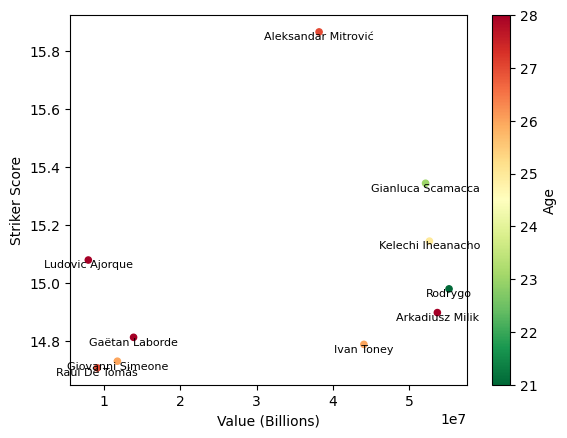

In [5]:

num = 10
scatter = fm23.head(num).plot.scatter(x = "Value", y = "Striker Score", c="Age", colormap="RdYlGn_r",)

# Set labels
plt.xlabel('Value (Billions)')
plt.ylabel('Striker Score')

# Add data labels using annotations
for index, row in fm23.head(num).iterrows():
    plt.text(row['Value'], row['Striker Score'], row['Name'], fontsize=8, ha='center', va='top')

# Show the plot
plt.show()

Next, I want to look at the potential of the players. Not all players have reached their full in-game potential yet so I want to see if any of the top 10 strikers can still improve in the game. I do this by plotting a bar chart to show the in-game level of the player and introducing the error-bar as the potential. This shows me how much the individual player can improve in the game.

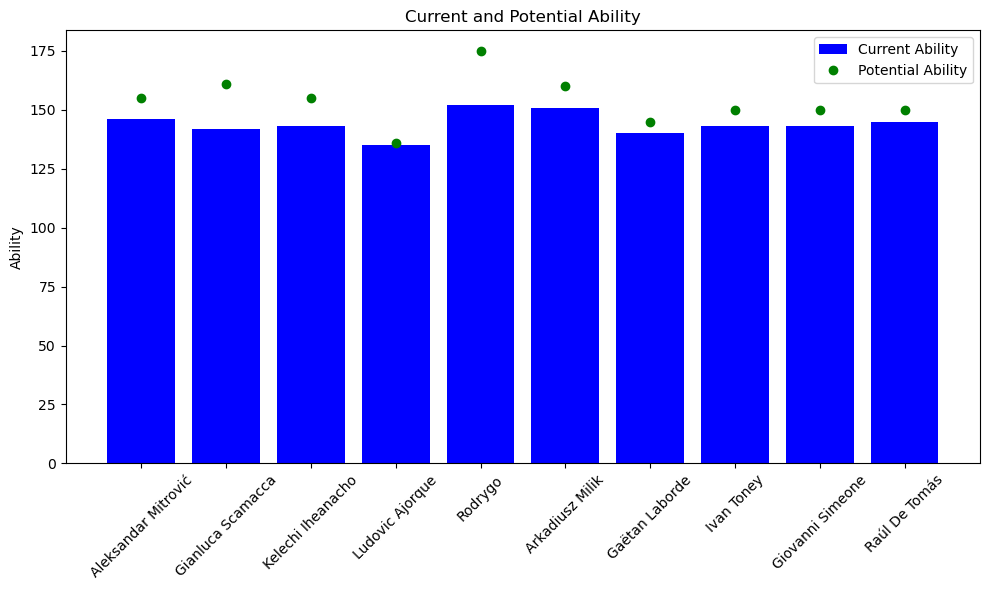

In [6]:
fm23_head = fm23.head(num)

import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot for Current Ability
plt.figure(figsize=(10, 6))

# Plot bars for Current Ability
plt.bar(fm23_head['Name'], fm23_head['Current Ability'], color='blue', label='Current Ability')

# Plot whiskers for Potential Ability
plt.errorbar(fm23_head['Name'], fm23_head['Potential Ability'], fmt='o', color='green', label='Potential Ability')

# Set labels and title
plt.ylabel('Ability')
plt.title('Current and Potential Ability')

# Set tick locations and labels, and rotate x-labels vertically
plt.xticks(range(len(fm23_head['Name'])), fm23_head['Name'], rotation=180)

# Add legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Having looked at the overall level, value and potential of each of the top 10 players, I want to compare them in detail. To do this, I will use a radar plot to compare the 6 player traits defined in the striker utility function above. The radar plot plots the stats of two selected strikers so that I can easily compare them. The plot also allows me to look at strikers outside the top 10 if I want to search for other alternatives.

I am aware that the code creates 3 plots where only the middle ones works as it should but I have been unable to fix this.

In [16]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact

# Initialize an empty figure object
fig = go.Figure()

def plot_s(Name1, Name2):
    global fig  # Use the global variable fig
    
    # Get data for the first line
    player_data1 = fm23[fm23['Name'] == Name1]
    stats1 = player_data1.iloc[:, 7:13] 
    stats_mean1 = stats1.mean()
    
    # Get data for the second line
    player_data2 = fm23[fm23['Name'] == Name2]
    stats2 = player_data2.iloc[:, 7:13]  
    stats_mean2 = stats2.mean()
    
    # Clear existing traces
    fig.data = []
    
    # Add new trace for the first line
    fig.add_trace(go.Scatterpolar(
        r=list(stats_mean1.values) + [stats_mean1.values[0]],  # Duplicate the first value to close the plot
        theta=list(stats_mean1.index) + [stats_mean1.index[0]],  # Duplicate the first index to close the plot
        fill='toself',
        hoverinfo='none',
        name=Name1  # Set the name for the legend
    ))
    
    # Add new trace for the second line
    fig.add_trace(go.Scatterpolar(
        r=list(stats_mean2.values) + [stats_mean2.values[0]],  # Duplicate the first value to close the plot
        theta=list(stats_mean2.index) + [stats_mean2.index[0]],  # Duplicate the first index to close the plot
        fill='toself',
        hoverinfo='none',
        name=Name2  # Set the name for the legend
    ))

    # Update layout of the figure
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 20] 
            )
        ),
        title=f'Ability comparison between {Name1} and {Name2}'
    )
    
    # Show the updated figure
    fig.show()

# Get unique player names
player_names = fm23['Name'].unique()

# Create dropdown widgets for each line
name_dropdown1 = widgets.Dropdown(description="Player 1", options=player_names, value=player_names[0])
name_dropdown2 = widgets.Dropdown(description="Player 2", options=player_names, value=player_names[1])

# Make the plot interactive
interact(plot_s, Name1=name_dropdown1, Name2=name_dropdown2)

# Display the initial empty figure
fig



interactive(children=(Dropdown(description='Player 1', options=('Aleksandar Mitrović', 'Gianluca Scamacca', 'K…